In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
market_caps = pd.read_csv("data/new/market_caps.csv")
prices = pd.read_csv("data/new/prices.csv")
volumes = pd.read_csv("data/new/volumes.csv")
coins = pd.read_csv("data/new/coins.csv")['coins'].values

In [3]:
#rebalance portfolio of coins given target allocations, rebalance period, and start and end dates
def period_rebalance(coins, ps, period=42, allocations="equal", starting=1000000, from_date="2018-01-01", to_date="2023-01-15"):
    n = len(coins)
    
    if allocations=='equal':
        weights = dict(zip(coins, n*[1./n]))
    else:
        weights = allocations
    
    prices = ps.loc[(ps['date']>=from_date) & (ps['date']<=to_date)]
    prices.reset_index(inplace=True)
    
    dates = prices['date'].to_numpy()
    days = len(dates)
    
    rebalance_df = pd.DataFrame({'date':dates})
    rebalance_df['portfolio_value'] = pd.Series(dtype='float64')
    for coin in coins:
        rebalance_df[coin+'_percent'] = pd.Series(dtype='float64')
        rebalance_df[coin+'_value'] = pd.Series(dtype='float64')
        rebalance_df[coin+'_amount'] = pd.Series(dtype='float64')
        
    rebalance_df.at[0, 'portfolio_value'] = starting
    for coin in coins: 
        rebalance_df.at[0, coin+'_percent'] = 100*weights[coin]
        rebalance_df.at[0, coin+'_value'] = starting*weights[coin]
        rebalance_df.at[0, coin+'_amount'] = starting*weights[coin]/prices.loc[0,coin+'_price']
        
    for i in range(1,days):
        new_total = 0
        for coin in coins:
            coin_amount = rebalance_df.loc[i-1, coin+'_amount']
            new_price = prices.loc[i, coin+'_price']
            new_value = new_price*coin_amount
            rebalance_df.at[i, coin+'_value'] = new_value
            rebalance_df.at[i, coin+'_amount'] = coin_amount
            new_total += new_value
            
        rebalance_df.at[i, 'portfolio_value'] = new_total
        for coin in coins:
            new_coin_percent = rebalance_df.loc[i, coin+'_value']/new_total * 100
            rebalance_df.at[i, coin+'_percent'] = new_coin_percent
            
        
        if i%period == 0:
            for coin in coins:
                new_value = weights[coin]*rebalance_df.loc[i, 'portfolio_value']
                new_amount = new_value/prices.loc[i, coin+'_price']
                new_percent = 100*weights[coin]
                
                rebalance_df.at[i, coin+'_percent'] = new_percent
                rebalance_df.at[i, coin+'_value'] = new_value
                rebalance_df.at[i, coin+'_amount'] = new_amount
        
        
    return rebalance_df

#rebalance top n coins (by current market cap) over a time period when data exists for all coins
def rebalance(n, coins_all, ps, period=42, allocations="equal", starting=1000000):
    coins = coins_all[:n]
    
    not_null = ~prices[coins[0]+"_price"].isna()
    for coin in coins[1:]:
        not_null = not_null & ~prices[coin+"_price"].isna()
        
    dates = ps[not_null]["date"]
    
    from_date = dates.iloc[0]
    to_date = dates.iloc[-1]
    return period_rebalance(coins, ps, period=period, allocations=allocations, starting=starting, from_date=from_date, to_date=to_date)

In [4]:
#buy and hold of coins given target allocations and start and end dates
def buy_and_hold(coins, ps, allocations="equal", starting=1000000, from_date="2018-01-01", to_date="2023-01-15"):
    n = len(coins)
    
    if allocations=='equal':
        weights = dict(zip(coins, n*[1./n]))
    else:
        weights = allocations
    
    prices = ps.loc[(ps['date']>=from_date) & (ps['date']<=to_date)]
    prices.reset_index(inplace=True)
    
    dates = prices['date'].to_numpy()
    days = len(dates)
    
    df = pd.DataFrame({'date':dates})
    df['portfolio_value'] = pd.Series(dtype='float64')
    for coin in coins:
        df[coin+'_percent'] = pd.Series(dtype='float64')
        df[coin+'_value'] = pd.Series(dtype='float64')
        df[coin+'_amount'] = pd.Series(dtype='float64')
        
    df.at[0, 'portfolio_value'] = starting
    for coin in coins: 
        df.at[0, coin+'_percent'] = 100*weights[coin]
        df.at[0, coin+'_value'] = starting*weights[coin]
        df.at[0, coin+'_amount'] = starting*weights[coin]/prices.loc[0,coin+'_price']
        
    for i in range(1,days):
        new_total = 0
        for coin in coins:
            coin_amount = df.loc[i-1, coin+'_amount']
            new_price = prices.loc[i, coin+'_price']
            new_value = new_price*coin_amount
            df.at[i, coin+'_value'] = new_value
            df.at[i, coin+'_amount'] = coin_amount
            new_total += new_value
            
        df.at[i, 'portfolio_value'] = new_total
        for coin in coins:
            new_coin_percent = df.loc[i, coin+'_value']/new_total * 100
            df.at[i, coin+'_percent'] = new_coin_percent
        
    return df

#buy and hold of top n coins (by current market cap) over a time period when data exists for all coins
def top_n_buy_and_hold(n, coins_all, ps, allocations="equal", starting=1000000):
    coins = coins_all[:n]
    
    not_null = ~prices[coins[0]+"_price"].isna()
    for coin in coins[1:]:
        not_null = not_null & ~prices[coin+"_price"].isna()
        
    dates = ps[not_null]["date"]
    
    from_date = dates.iloc[0]
    to_date = dates.iloc[-1]
    return buy_and_hold(coins, ps, allocations=allocations, starting=starting, from_date=from_date, to_date=to_date)

In [5]:
df = rebalance(10, coins, prices, period=200)
dfbh = top_n_buy_and_hold(10, coins, prices)

In [6]:
def top_10_portfolio_plot(coins, prices, period=200):
    fig, ax = plt.subplots(2, 1, figsize=(20,15), sharex=True)
    ax1 = ax[0]
    ax2 = ax[1]
    plt.subplots_adjust(wspace=0, hspace=0)
    
    df = rebalance(10, coins, prices, period=period)
    dfbh = top_n_buy_and_hold(10, coins, prices)

    n = df.shape[0]
    ax1.plot(df['date'].values, prices['bitcoin_price'][-n:].values/prices['bitcoin_price'][-n:].values[0], label='btc')
    ax1.plot(prices['ethereum_price'][-n:].values/prices['ethereum_price'][-n:].values[0], label='eth')
    ax1.plot(df["portfolio_value"].values/df["portfolio_value"].values[0], label='rebal')
    ax1.plot(dfbh["portfolio_value"].values/dfbh["portfolio_value"].values[0], label='bandh')
    ax1.xaxis.set_ticks(np.arange(0,n,period))
    ax1.yaxis.set_ticks(np.arange(0,60,10))
    ax1.set_ylim(ymin=0)
    ax1.grid(True, color='k', linestyle='-')
    ax1.legend()

    allocations = df[[c+'_percent' for c in coins[:10]]].values.T
    ax2.xaxis.set_ticks(np.arange(0,n,period))
    ax2.yaxis.set_ticks(np.arange(0,110,10))
    ax2.grid(True, color='k', linestyle='-')
    ax2.stackplot(df['date'].values, allocations[0], allocations[1], allocations[2], allocations[3], allocations[4], allocations[5], allocations[6], allocations[7], allocations[8], allocations[9], labels=coins[:10])
    ax2.set_ylim(ymax=100)
    plt.xticks(rotation=90)
    ax2.legend()

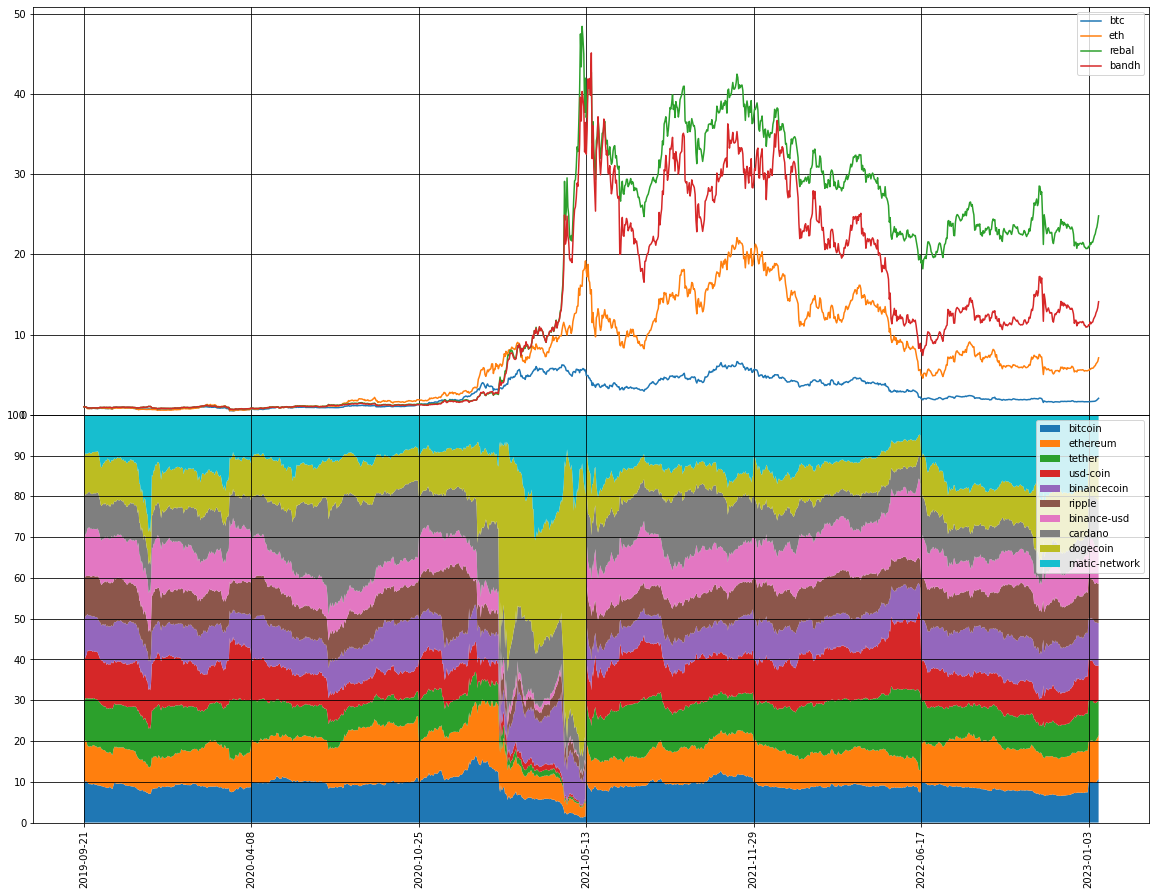

In [7]:
top_10_portfolio_plot(coins, prices, period=200)

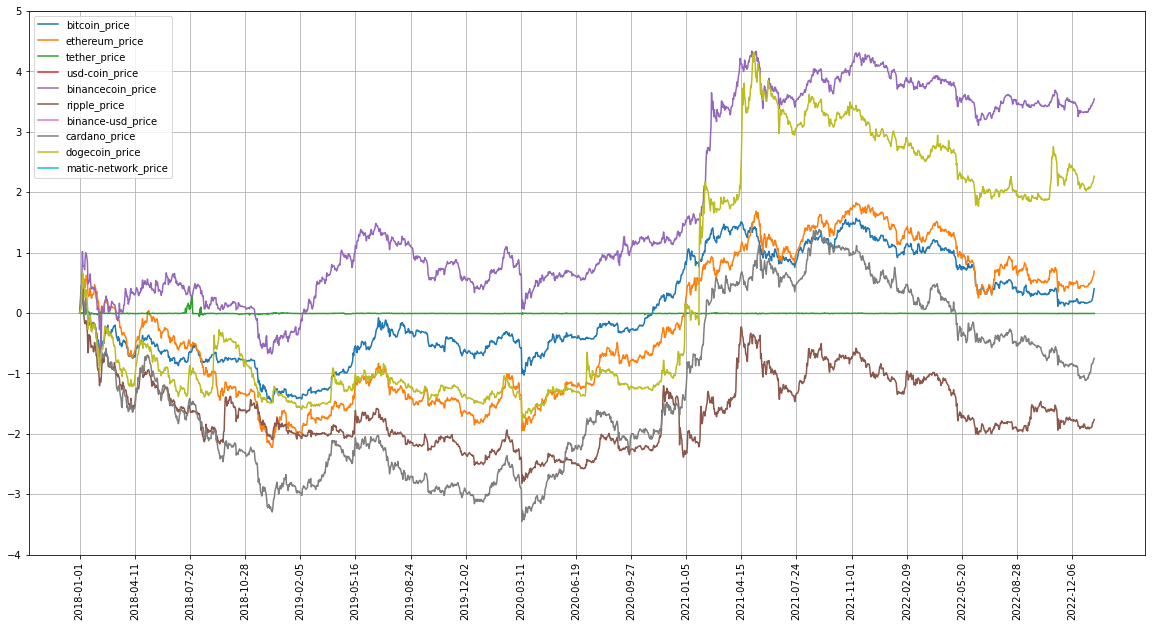

In [8]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for i in range(1,10+1):
    series = np.log(prices[prices.columns.values[i]].values*1/prices[prices.columns.values[i]].iloc[0])
    plt.plot(prices['date'], series, label=prices.columns.values[i])
    
ax.xaxis.set_ticks(np.arange(0,1840,100))
ax.yaxis.set_ticks(np.arange(-4,6,1))
ax.grid(True)

plt.xticks(rotation=90)
plt.legend()